# Retro table Compression

This notebook discusses possibilities on how the decompose the 5d table into lower dimensionalities to compress them

In [13]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn.decomposition import IncrementalPCA as PCA
from numba import jit, float64, int32, float32, guvectorize, SmartArray

In [4]:
string = 'dc'
depth = 55

# memory map a 5d table
#table_5d = np.load('/fastio2/icecube/retro/tables/large_5d_notilt_string_%s_depth_%s/ckv_table.npy'%(string, depth), mmap_mode='r')
table_5d = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_%s_depth_%s/ckv_table.npy'%(string, depth), mmap_mode='r')

In [5]:
# tables are binned in r, theta, t, theta_dir, delta_phi_dir
table_5d.shape

(100, 40, 250, 80, 40)

In [6]:
# create 3d table
table_3d = np.sum(table_5d, axis=(3,4))
table_3d.shape

(100, 40, 250)

In [7]:
# normalize the tables such that all directionality maps sum to 1
table_5d_normed = np.nan_to_num(table_5d / table_3d[:,:,:,np.newaxis,np.newaxis])

/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


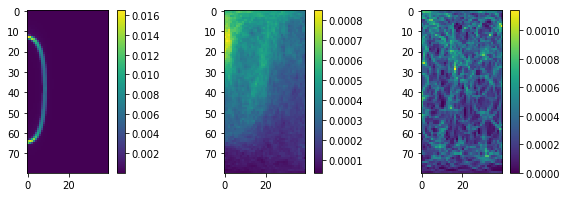

In [8]:
# Plot some example maps
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
im1 = ax1.imshow(table_5d_normed[5,20,0])
cbar = plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(table_5d_normed[5,20,3])
cbar = plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(table_5d_normed[5,20,20])
cbar = plt.colorbar(im3, ax=ax3)

The idea is to replace all directionality maps by templates, under the assumptions that many maps will look the same and this redundancy can be reduced.

In order to do this we do the following:
* a directionality map is 80x40 pixels, which means 3200 dimensional
* for clustering this dimensionality is extremely high
* we use a priciple component analysis (PCA) to extract the important features of all maps
* leaving us with e.g. 200 dimensions
* on this space we can use k-means clustering to identify similar maps
* once clusters have been found, a template is generated to represent each cluster (this is the average of all memebrs of a cluster)

In [22]:
%%time
# prepare data structure
# reject low stats samples (these contian a lot of specific shapes just due to too low statistics. we don't want to add these shapes to our template library)
mask = table_3d < 1000.
# reduced data
data = np.empty((np.product(table_5d.shape[:3])-np.sum(mask),np.product(table_5d.shape[3:])))
counter = 0
for i,m in np.ndenumerate(mask):
    if not m:
        data[counter] = table_5d_normed[i].ravel()
        counter += 1

CPU times: user 3.49 s, sys: 6.42 s, total: 9.92 s
Wall time: 9.92 s


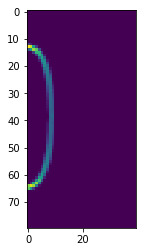

In [25]:
plt.imshow(data[100].reshape(80,40))

In [26]:
%%time
# do a principal component analysis in order to reduce the dimensionality for the clustering
pca = PCA(n_components = 100)
pca.partial_fit(data)

CPU times: user 21min 17s, sys: 2min 15s, total: 23min 32s
Wall time: 23min 34s


In [27]:
import cPickle as pickle
with open('pca.pkl','wb') as f:
    pickle.dump(pca, f)

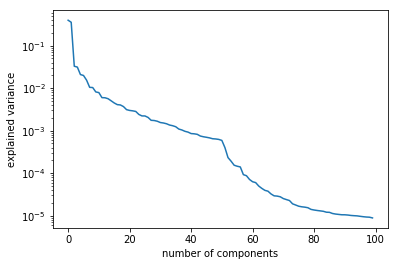

In [28]:
#how many components are necessary?
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
#pca.explained_variance_ratio_
plt.gca().set_yscale('log')
plt.xlabel('number of components')
plt.ylabel('explained variance')

In [29]:
%%time
# reduced data
reduced_data = pca.fit_transform(data)

KeyboardInterrupt: 

In [112]:
%%time
# restore the data (just for inspection, not used in algorithm)
restored_data = pca.inverse_transform(reduced_data)
restored_data = restored_data.reshape(table_5d.shape)

CPU times: user 22.4 s, sys: 14.4 s, total: 36.9 s
Wall time: 36.8 s


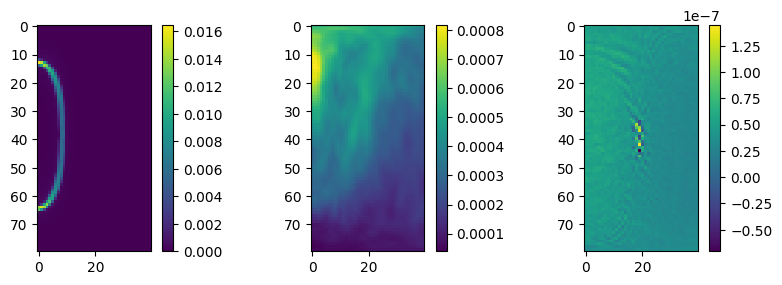

In [130]:
# Plot restored distributions to see how they look like
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
im1 = ax1.imshow(restored_data[5,20,0])
cbar = plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(restored_data[5,20,3])
cbar = plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(restored_data[5,20,20])
cbar = plt.colorbar(im3, ax=ax3)

In [114]:
%%time
# clsuter using k-means
n_clusters=500
k_means = cluster.KMeans(n_clusters=n_clusters, n_jobs=-1)
k_means.fit(reduced_data)

CPU times: user 24 s, sys: 25 s, total: 49 s
Wall time: 32min 43s


In [118]:
# build template library
templates = []
templates_n = []
for j in range(500):
    imgs = data[np.where(k_means.labels_==j)[0]]
    n = imgs.shape[0]
    templates_n.append(n)
    template = np.average(imgs, axis=0)
    template = template.reshape(80,40)
    templates.append(template)

In [237]:
# sort them (not important, just nicer to look at)
templates = [x for _,x in sorted(zip(templates_n,templates), reverse=True, key=lambda x: x[0])]
templates_n = sorted(templates_n, reverse=True)
# Cannot have zero template
for i in range(len(templates)):
    if np.sum(templates[i]) == 0:
        print 'subst.'
        templates[i] = np.ones_like(templates[i])
    templates[i] /= np.sum(templates[i])

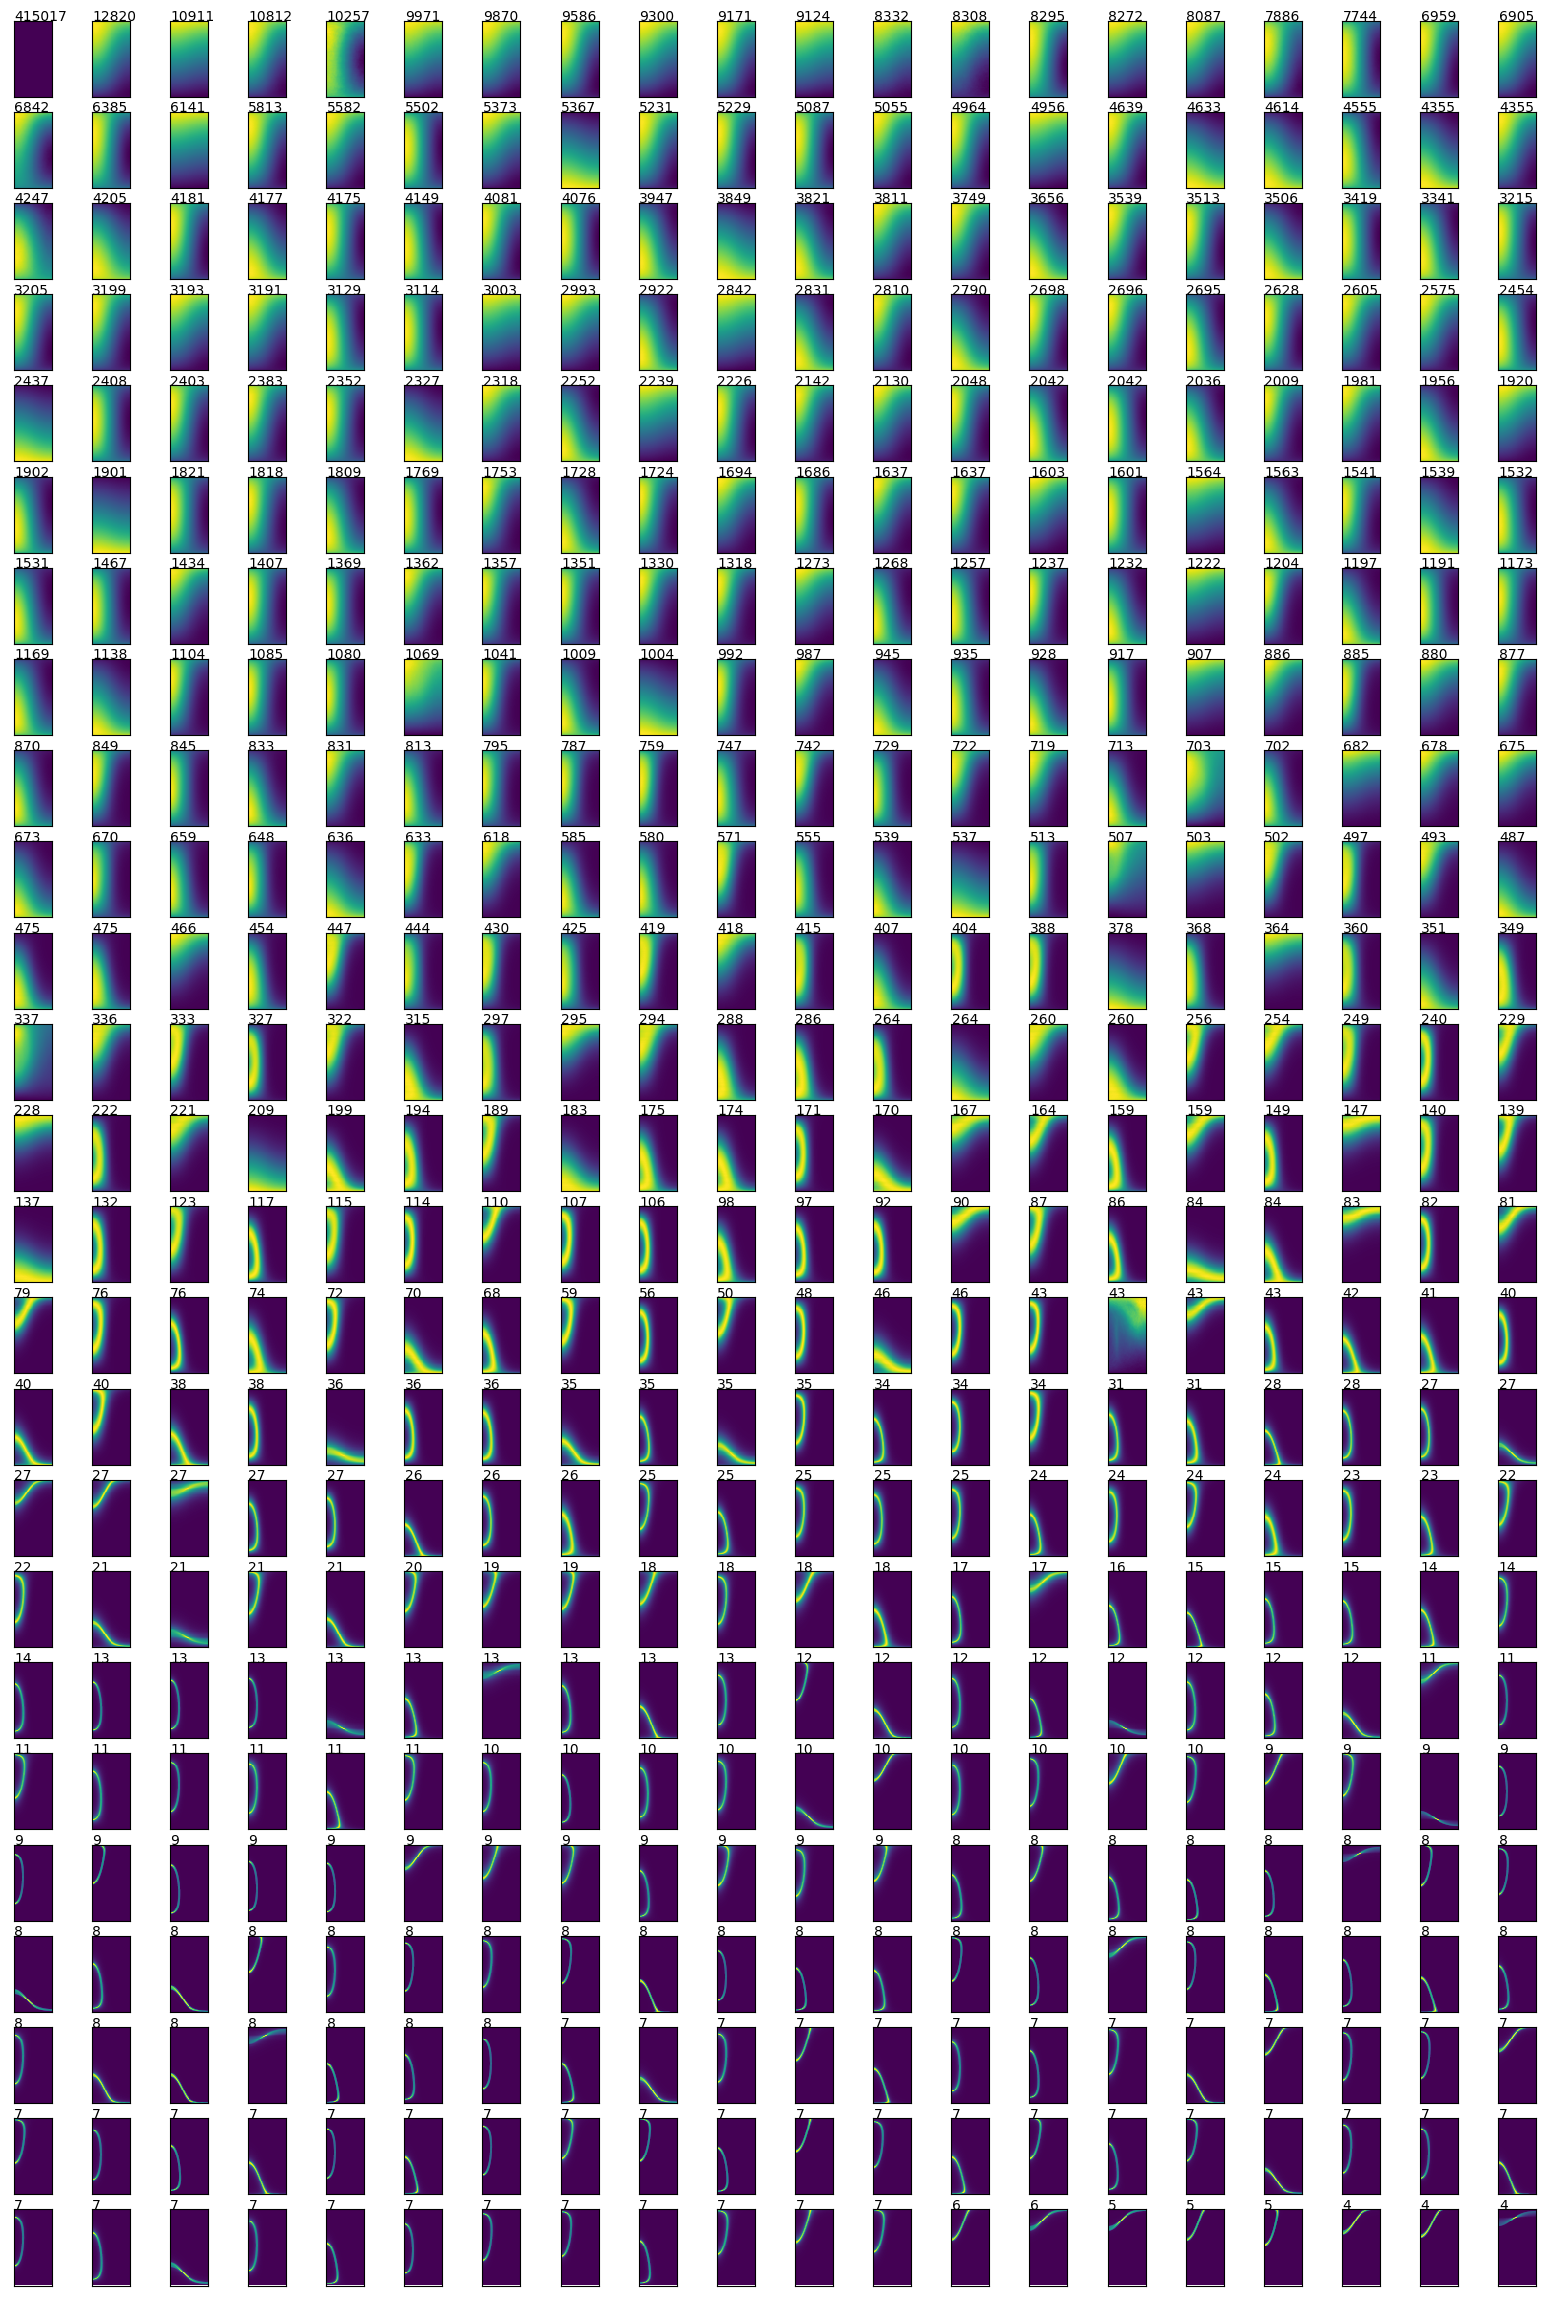

In [125]:
fig, axes = plt.subplots(figsize=(20, 30), ncols=20, nrows=25)
for j in range(500):
    axes[j/20,j%20].imshow(templates[j])
    axes[j/20,j%20].set_xticks([])
    axes[j/20,j%20].set_yticks([])
    axes[j/20,j%20].text(0,0,templates_n[j])
plt.savefig('labels.png', dpi=600)

In [238]:
templates = np.stack(templates, axis=0)

In [9]:
templates = np.load('../table_compression/final_templates.npy')

In [10]:
templates = templates.astype(np.float32)

In [14]:
templates = SmartArray(templates)

Now we want to assign a template library index to every bin in the 3d table.
We can do that by finding the template closest to the original map for every bin

In [272]:
#@jit(nopython=False, nogil=True, cache=True)
#def find_best_template(dir_map, templates):
#    '''
#    Find the best template for a given directionality map
#    
#    dir_map : array of size (m,n)
#    templates : array of size (k,m,n)
#    returns int in range(k)
#    '''
#    new_map = dir_map[np.newaxis, :, :]
#    chi2s = np.sum(np.nan_to_num(np.square(templates - new_map) / (templates + new_map)), axis=(1,2))
#    return np.argmin(chi2s)

In [15]:
# vectorized chi2 calculator
@guvectorize(['(f4[:,:],f4[:,:],f4[:])'], '(a,b),(a,b)->()', target='cuda')
def tot_chi2(dir_map, templates, chi2s):
    for j in range(dir_map.shape[0]):
        for k in range(dir_map.shape[1]):
            A = dir_map[j, k]
            B = templates[j, k]
            tot = A + B
            if tot == 0.:
                continue
            chi2s[0] += (A-B)**2/tot

In [52]:
@jit(nopython=True, nogil=True, cache=True)
def find_best_template_cpu(dir_map, templates):
    '''
    Find the best template for a given directionality map
    
    dir_map : array of size (m,n)
    templates : array of size (k,m,n)
    returns int in range(k)
    '''
    chi2s = np.zeros(templates.shape[0], np.float32)
    if np.sum(dir_map) == 0.:
        return 0
    for i in range(templates.shape[0]):
        for j in range(dir_map.shape[0]):
            for k in range(dir_map.shape[1]):
                A = dir_map[j, k]
                B = templates[i, j, k]
                tot = A + B
                if tot == 0.:
                    continue
                chi2s[i] += (A-B)**2/tot
    return np.argmin(chi2s)

In [63]:
#@jit(nopython=True, nogil=True, cache=True)
def find_best_template(dir_map, templates):
    '''
    Find the best template for a given directionality map
    
    dir_map : array of size (m,n)
    templates : array of size (k,m,n)
    returns int in range(k)
    '''
    if np.sum(dir_map) == 0.:
        return 0
    chi2s = np.zeros(templates.get('host').shape[0], np.float32)
    tot_chi2(dir_map, templates.get('gpu'), out=chi2s)
    return np.argmin(chi2s)

In [64]:
# fill index table
#@jit(nopython=True, nogil=True, cache=True)
def fill_index_table(table_5d_normed, templates):
    index_table = np.zeros(table_5d_normed.shape[:3], dtype=np.uint16)
    for i in range(index_table.shape[0]):
        print i
        for j in range(index_table.shape[1]):
            for k in range(index_table.shape[2]):
                index_table[i,j,k] = find_best_template(table_5d_normed[i,j,k], templates)
    return index_table

In [66]:
%%time
index_table = fill_index_table(table_5d_normed[:10,:,:,:,:], templates)

0
1
2
3
4
5
6
7
8
9
CPU times: user 2min 28s, sys: 40.5 s, total: 3min 9s
Wall time: 3min 9s


In [53]:
%%time
index_table_cpu = fill_index_table(table_5d_normed[:2,:,:,:,:], templates)

0
1
CPU times: user 46.8 s, sys: 1.16 s, total: 47.9 s
Wall time: 47.9 s


In [57]:
np.where(index_table[1] != index_table_cpu[1])

(array([], dtype=int64), array([], dtype=int64))

In [418]:
# save
np.save('/data/icecube/retro_tables/tiny_tables/string_%s_depth_%s/ckv_template_library.npy'%(string, depth), templates)
#np.save('/data/icecube/retro_tables/tiny_tables/string_%s_depth_%s/index_table.npy'%(string, depth), index_table)
#np.save('/data/icecube/retro_tables/tiny_tables/string_%s_depth_%s/photon_table.npy'%(string, depth), table_3d)
np.save('/data/icecube/retro_tables/tiny_tables/string_%s_depth_%s/ckv_template_map.npy'%(string, depth), template_map)

In [395]:
# custom dtype
tabledt = np.dtype([('index', np.uint16), ('weight', np.float32)])

In [406]:
@jit(nopython=True, nogil=True, cache=True)
def fill_template_map(index_table, table_3d):
    template_map = np.zeros(table_5d_normed.shape[:3], dtype=tabledt)
    for i in range(template_map.shape[0]):
        for j in range(template_map.shape[1]):
            for k in range(template_map.shape[2]):
                template_map[i,j,k]['index'] = index_table[i,j,k]
                template_map[i,j,k]['weight'] = table_3d[i,j,k]
    return template_map

In [428]:
template_map = fill_template_map(index_table, table_3d)

1.39912e+07


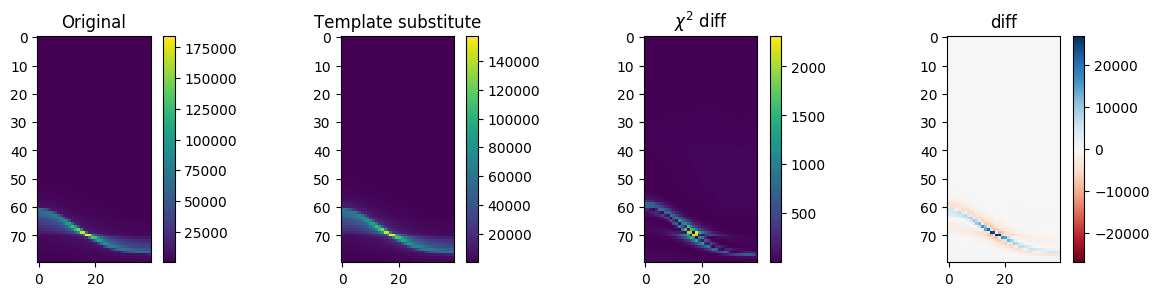

In [421]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 3), ncols=4)

r_idx = 8
cz_idx = 0
t_idx = 1

A = table_5d[r_idx, cz_idx, t_idx]
#B = templates[find_best_template(A, templates)]
index, weight = template_map[r_idx, cz_idx, t_idx]
B = templates[index] * weight
print np.sum(B)

im1 = ax1.imshow(A)
cbar = plt.colorbar(im1, ax=ax1)
ax1.set_title('Original')
im2 = ax2.imshow(B)
cbar = plt.colorbar(im2, ax=ax2)
ax2.set_title('Template substitute')
im3 = ax3.imshow(np.square(A-B)/(A+B))
cbar = plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$\chi^2$ diff')
im4 = ax4.imshow(A-B, vmin=-np.max(np.abs(A-B)), vmax=np.max(np.abs(A-B)), cmap='RdBu')
cbar = plt.colorbar(im4, ax=ax4)
ax4.set_title('diff')

NameError: name 'np' is not defined